## Computational Perception Assignment 3

Brennan McFarland

### Imports and convenience functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi, sin, cos
import sounddevice as sd
import scipy.io.wavfile as wavfile
from scipy.optimize import minimize_scalar
from sklearn.preprocessing import normalize
import time

In [2]:
def open_wav(filename):
    srate, waveform = wavfile.read(filename)
    waveform = np.divide(waveform, 16384)
    return srate, waveform

### Exercise 1. The Duplex Theory (25 points)

**Figure IIDvsAz: Interaural Intensity Difference vs. Azimuth (at different frequencies)**

<img src="moore-fig6-2.jpg" align="left" style="width: 500px;"/>

**Figure MAAvsF: Minimum audible angle vs. Frequency (ploted by azimuth)**

<img src="moore-fig6-5.jpg" align="left" style="width: 400px;"/>

1.1 (10 pts) Describe three features of figure IIDvsF that would be predicted by duplex theory.

Duplex theory postulates that in human hearing, ITDs are used to localize sounds of lower frequency and IIDs are used to localize sounds at higher frequencies.

1. One feature of the figure predictable by duplex theory is that as frequency increases, IID as a function of angle from azimuth changes from almost an entirely flat line at around 200Hz to more of an arch/parabola around 6000Hz.  That is, at higher frequencies the IID as a function of angle has a higher variance.  Duplex theory predicts this as a higher variance in the underlying signal we're trying to detect means a higher SNR (assuming a fixed noise level) and thus a higher capacity (as in entropic capacity) for what can be retrieved from the noisy signal.  Thus, at higher frequencies we can get more accurate predictions of the angle from azimuth given only the IID than at lower frequencies, which fits with duplex theory's assertion of IIDs being used for sound localization at higher frequencies as that is when they would be more effective.

2. Another feature duplex theory would predict based on its assertion that IIDs are useful for us to do sound localization at all is that the functions for IID as a function of angle from azimuth is approximately symmetric for a given frequency, with a symmetry axis around 90 degrees.  This might seem like evidence against the utility of IIDs for sound localization as even when the curves have sufficient variance to distinguish them from noise as explained in 1., the localization ambiguity is still only reduced to two possible locations (or regions, given that there is also noise): the two points with the same IID, lying at approximately the same angle from 90 degrees past the azimuth.  However, this makes sense in the case of human biology because sound localization is aided by vision, that is, if the source of a sound is within our visual field we can infer based on what we see where the sound is coming from.  Thus, our brains can make inferences about which of these two points the sound is coming from: if we can see it, then we can infer the origin of the sound is less than 90 degrees from the azimuth (in front of us), and if we can't, we can infer it is not, ie, it is more than 90 degrees from the azimuth (behind us).  Although the human visual span is not quite 180 degrees, the missing range of angles is small enough, the two potential localizations are small enough/the points on the curve are close enough that we still get a good enough estimate of the direction the sound is coming from.  Thus duplex theory predicts that less resources need to be dedicated to localizing sound with IIDs due to other factors usable in conjunction, still making it an effective tool for sound localization.

3. Similarly, the changing slope of the IIDs as functions of angle from azimuth for a given frequency could be predicted by duplex theory.  As can be seen in the figure, these slopes are greatest around 0 and 180 degrees from the azimuth, which means higher variance in the signal in those regions and thus better, more accurate localizations, for the reasons explained in 1., than at around 90 degrees, where the slope is usually close to 0.  This implies higher resolution sound localization from close to directly in front and behind compared to from the sides, which would likely be more valuable from an evolutionary standpoint as it would allow us to better localize the sounds from whatever areas we're looking at, searching or observing, and to better pinpoint the direction of potential threats that could be chasing or sneaking up on us from behind.  Thus duplex theory would predict that better sound localization from in front and behind would be favored, something apparent from the IID vs angle measurements in the figure.

1.2 (10 pts) Describe a feature of the curves in either figure IIDvsF or MAAvsAz that is not explained by duplex theory.  What might be the source of this?

In the IIDvsAz figure, the curves of IID as a function of angle from the azimuth are generally more noisy between 90 and 180 degrees than they are between 0 and 90 degrees, which would seem to hamper effective sound localization using IIDs even at higher frequencies, which duplex theory says is its main purpose, and from behind, which as stated in part 3. of the last problem would be especially useful from an evolutionary standpoint.  The source of this noise is likely due to the shape of the head and ears.  The IIDs of incoming sounds are shaped by the way sound is muffled and obstructed by the shape of the head and the pinnae, the latter of which in particular would have a more profound disruptive effect on sounds coming from behind due to their shape.

1.3 (5 pts) Describe the functional significance of the pinnae.

Several theories have attempted to explain the pinnae's functional significance.  These include its use as a mechanism for gathering sound waves, as vestigial structures from when we could move our ears, and as a way to help shape incoming sounds so as to better distinguish sounds coming from the front versus the back.  More recent theories like Batteau's postulate that the pinnae create echoes that create lateral and elevation cues to aid in localization.  The pinna then, along with the ear canal, results in a system of acoustic resonators that enable more accurate sound localization in 3D space.

### Exercise 2. Lateralization with ITD (30 points)

<img src="headfig.png" align="left" style="width: 250px;"/>

In this problem you will create a set of sound waveforms to listen to and experiment with.  You will need headphones or earphones.

We will define that locations in front of the head have 0$^\circ$
azimuth and locations in front of the left ear have -90$^\circ$
azimuth.  Assume a simplified model of the human head in which the
head is spherical.  Also assume that sound sources are infinitely far away, so that sound reaches the ears in straight lines (see
figure).  With this model the ITD ($\Delta t$) is:

$$ \Delta t = \frac{r}{c} (\theta+\sin(\theta)) $$

where $r=9~\textrm{cm}$ is the radius of the head. Assume the speed of sound is $c= 345~m/s$ (at $23^\circ$C).

2.1 (5 points) Write a function to create a sine wave of a specified frequency (Hz), duration (seconds), and sampling rate (Hz).  Illustrate it with plots.

In [66]:
# I made two functions, one takes an existing array as a domain and the other makes its own, for convenience
def _sine_wave(domain, freq, secs, srate, return_domain=False):
    wave = np.sin(domain * 2 * pi * freq)
    if return_domain:
        return domain, wave
    else:
        return wave

def sine_wave(freq, secs, srate, return_domain=False):
    return _sine_wave(np.linspace(0, secs, secs*srate), freq, secs, srate, return_domain=return_domain)

In [67]:
def plot_wave(domain, codomain, xlabel='time (s)', ylabel='normalized amplitude', show=True, **kwargs):
    plt.plot(domain, codomain, **kwargs)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if show:
        plt.show()

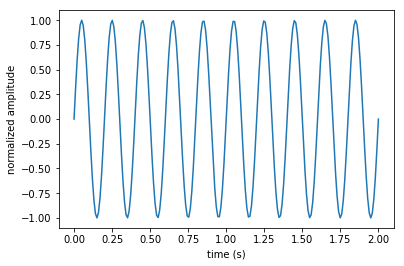

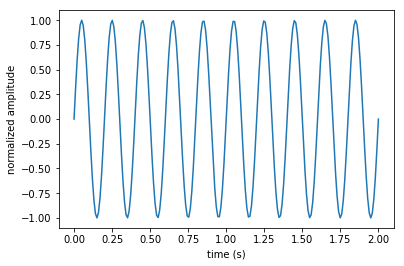

In [68]:
# illustrate with plots - I do so for both functions to verify for each
freq = 5
secs = 2
srate = 100
domain = np.linspace(0, secs, secs*srate)

for wave in (
    lambda: _sine_wave(domain, freq, secs, srate),
    lambda: sine_wave(freq, secs, srate)):

    codomain = wave()
    plot_wave(domain, codomain)
    

2.2 (10 points) Write a function that takes a sound waveform and an angle (in degrees) as input and returns (or creates) a stereo sound composed of both the left and right signals that reach the ears of the model listener.  Onset or offset transients will adversely affect the lateralization perception, so your function should remove them (using for example a Hanning window).  Demonstrate your function with a sine wave and with a real sound.

Since we are assuming the sound originates from a point infinitely far away and that the sound reaches each ear in straight lines, the distance from the sound source to each ear is the same and unaffected by the head, and thus there is no inter-aural intensity difference, and likewise we can ignore effects of the pinnae and head-related transfer functions.  The only difference then between the two stereo channels and the original mono sound waveform is the inter-aural time difference, which we can calculate as in the problem description:

In [186]:
# given angle in degrees, radius in meters, c in m/s, return itd in s
def get_itd(angle, radius=.09, c=345):
    theta = angle * pi / 180
    return abs(radius / c * (angle * sin(theta)))

In [187]:
# assumes channels have same sample rate
def pad_channels(channel_1, channel_2):
    channel_len_difference = len(channel_1) - len(channel_2)
    if channel_len_difference > 0:
        channel_2 = np.pad(channel_2, pad_width=(0, channel_len_difference), mode='constant', constant_values=0)
    elif channel_len_difference < 0:
        channel_1 = np.pad(channel_1, pad_width=(0, -channel_len_difference), mode='constant', constant_values=0)
    return channel_1, channel_2

# assumes channels have same sample rate and length
def mix_channels(channel_1, channel_2):
    return np.column_stack((channel_1, channel_2))

In [188]:
def convert_to_stereo(waveform, angle, srate, print_itd=False):
    itd = get_itd(angle)
    if print_itd:
        print('ITD: ', itd)
    left_channel = waveform
    right_channel = np.pad(waveform, pad_width=(int(itd*srate), 0), mode='constant', constant_values=0)
    # if angle < 0, we want the offset in the other direction, so we can just swap the channels
    if angle > 0:
        left_channel, right_channel = right_channel, left_channel
    return pad_channels(left_channel, right_channel)

In [189]:
def play_sound(data, srate, channels=1, sleep_time=1):
    if channels != 1:
        sd.play(data, srate, mapping=range(1, channels+1))
    else:
        sd.play(data, srate)
    time.sleep(sleep_time) # to let the sound finish playing uninterrupted

In [190]:
def sigmoid(x):
    return 1/(1+np.exp(-x))


def ramp_out(waveform, ramp_len, srate, ramp_approximation_window=6):
    ramp_sample_len = int(ramp_len * srate)
    ramp_range = np.linspace(ramp_approximation_window, -ramp_approximation_window, ramp_sample_len)
    ramp = sigmoid(ramp_range)
    ramp = np.pad(ramp, (waveform.shape[0] - ramp_sample_len, 0), mode='constant', constant_values=1)
    return ramp


# applies a sigmoid ramp
# ramp_len in seconds
# ramp_approximation is because sigmoid is asymptotic, so we just grab the range of values where it's close enough
def ramp_in(waveform, ramp_len, srate, ramp_approximation_window=6):
    ramp_sample_len = int(ramp_len * srate)
    ramp_range = np.linspace(-ramp_approximation_window, ramp_approximation_window, ramp_sample_len)
    ramp = sigmoid(ramp_range)
    ramp = np.pad(ramp, (0, waveform.shape[0] - ramp_sample_len), mode='constant', constant_values=1)
    return ramp


def apply_ramp(waveform, ramp_len, srate):
    in_ramp, out_ramp = ramp_in(waveform, ramp_len, srate), ramp_out(waveform, ramp_len, srate)
    return waveform * in_ramp * out_ramp

In [191]:
def stereo_and_ramp(wave, angle, srate, ramp_len, print_itd=False):
    channel_1, channel_2 = convert_to_stereo(wave, angle, srate, print_itd=print_itd)
    stereo_sound = mix_channels(channel_1, channel_2)
    channel_1 = apply_ramp(channel_1, ramp_len, srate)
    channel_2 = apply_ramp(channel_2, ramp_len, srate)
    stereo_sound[:, 0], stereo_sound[:, 1] = channel_1, channel_2
    return stereo_sound, channel_1, channel_2

In [192]:
# convenience class to make it easier to iteratively test each case
class SoundWave:
    def __init__(self, domain, codomain, srate):
        self.domain = domain
        self.codomain = codomain
        self.srate = srate


# gets a sine wave and real sound wave as example sounds
def get_example_sounds():
    # demonstrate with sine wave
    sine_srate = 44100
    sine_domain, sine_codomain = sine_wave(freq=100, secs=1, srate=sine_srate, return_domain=True)
    sine_sound_wave = SoundWave(sine_domain, sine_codomain, sine_srate)

    # demonstrate with real sound
    real_srate, real_codomain = open_wav('wilhelm_scream.wav')
    real_sound_wave = SoundWave(np.linspace(0, len(real_codomain) / real_srate, len(real_codomain)), real_codomain, real_srate)
    
    return sine_sound_wave, real_sound_wave

In [193]:
def play_and_plot(stereo_sound, sound_wave, xlabel='time (s)', ylabel='amplitude', overlay_channels=False):
    play_sound(stereo_sound, sound_wave.srate, channels=2)
    sound_len = len(stereo_sound[:, 0])
    if overlay_channels:
        alpha = .5
    else:
        alpha = 1
    plot_wave(np.linspace(0, sound_len / sound_wave.srate, sound_len), stereo_sound[:, 0], xlabel=xlabel, ylabel=ylabel,
              show=not overlay_channels)
    plot_wave(np.linspace(0, sound_len / sound_wave.srate, sound_len), stereo_sound[:, 1], xlabel=xlabel, ylabel=ylabel,
             alpha=alpha)    

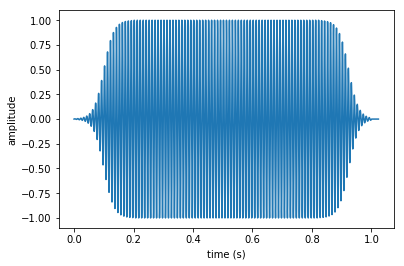

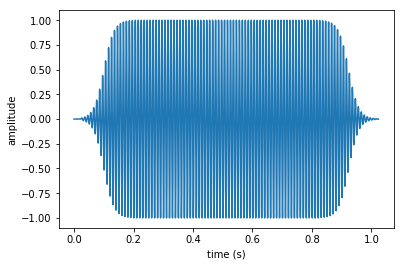

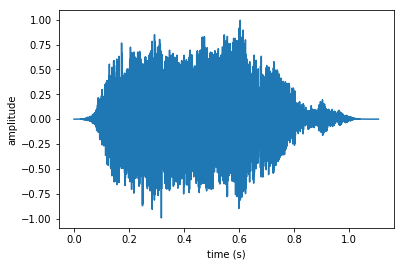

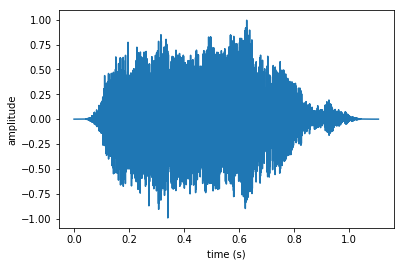

In [196]:
angle = 45

sine_sound_wave, real_sound_wave = get_example_sounds()

for sound_wave in (sine_sound_wave, real_sound_wave):
    stereo_sound, channel_1, channel_2 = stereo_and_ramp(sound_wave.codomain, angle, sound_wave.srate, .2)
    play_and_plot(stereo_sound, sound_wave)

2.3 (5 points)  Using the functions you created above, create a set of sounds at different "pure-tone" frequencies (include at least 200Hz and 2000Hz) that come from different angles.  Show the output by plotting the sounds with the left and right channels in different colors on the same axes.  

/home/iamroot/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/iamroot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.


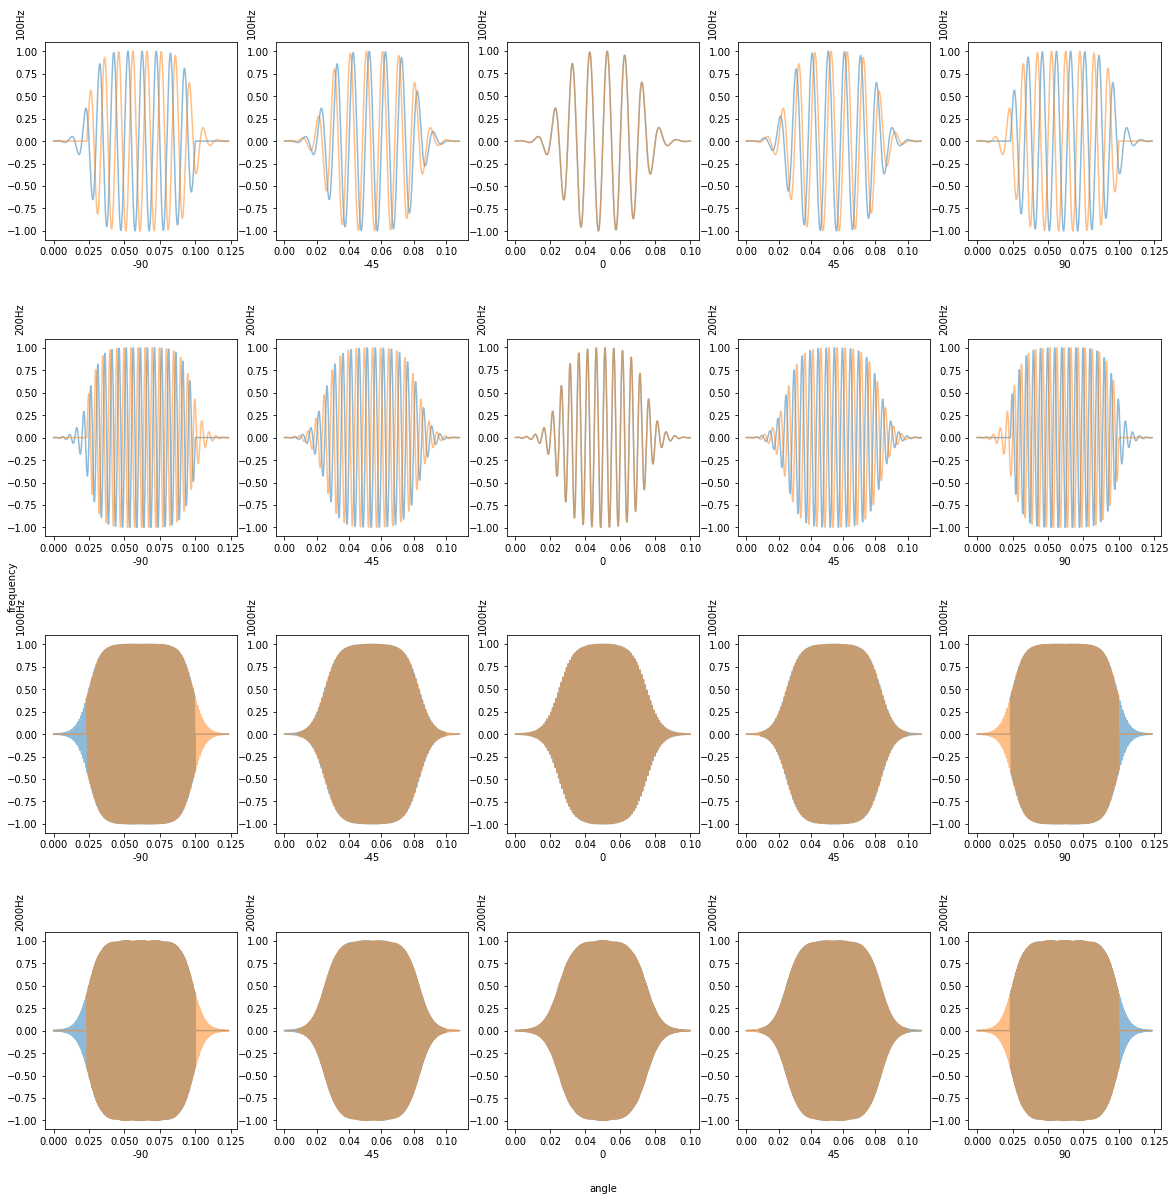

In [197]:
frequencies = (100, 200, 1000, 2000)
angles = (-90, -45, 0, 45, 90)
srate = 44100

fig = plt.figure(figsize=(20, 20))

# add an empty subplot for global axis labels
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.set_label_coords(.5, -.05)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
subplot_x, subplot_y = len(frequencies), len(angles)

plt.subplots_adjust(wspace=.2, hspace=.5)

tones = []

i = 0
for frequency in frequencies:
    for angle in angles:
        i += 1
        subax = fig.add_subplot(subplot_x, subplot_y, i)
        subax.yaxis.set_label_coords(-0.1,1.1)
        subax.xaxis.set_label_coords(.5, -0.1)

        domain, codomain = sine_wave(freq=frequency, secs=.1, srate=srate, return_domain=True)
        
        stereo_sound, channel_1, channel_2 = stereo_and_ramp(codomain, angle, srate, .05)
        
        # plot the sounds with the left and right channels in different colors on the same axes
        sound_len = len(channel_1)
        plot_wave(np.linspace(0, sound_len / srate, sound_len), channel_1, xlabel='', ylabel='', alpha=.5, show=False)
        plot_wave(np.linspace(0, sound_len / srate, sound_len), channel_2, xlabel=str(angle), ylabel=str(frequency) + 'Hz', alpha=.5, show=False)

        tones.append(stereo_sound)

ax.set_xlabel('angle')
ax.set_ylabel('frequency')
plt.show()

2.4 (5 points) Listen to those sounds with headphones.  Do you
perceive the sounds as coming from the same location or different
locations?  Describe your observations and explain.

In [198]:
for tone in tones:
        play_sound(tone, srate, channels=2, sleep_time=.5)

In [29]:
# TODO: explanation, but it definitely appears to be moving left to right as it should be

2.5 (5 points) Now try the 'note.wav' and 'sound.wav' sounds included with the assignmnet.  How does the perception of spatial position of the sine waves compare to the sine waves?

In [202]:
note_srate, note_codomain = open_wav('note.wav')
note_wave = SoundWave(np.linspace(0, len(note_codomain) / note_srate, len(note_codomain)), note_codomain, note_srate)
sound_srate, sound_codomain = open_wav('sound.wav')
sound_wave = SoundWave(np.linspace(0, len(sound_codomain) / sound_srate, len(sound_codomain)), sound_codomain, sound_srate)

for wave in (note_wave, sound_wave):
    for angle in angles:
        stereo_sound, channel_1, channel_2 = stereo_and_ramp(wave.codomain, angle, wave.srate, .2)
        play_sound(stereo_sound, wave.srate, channels=2, sleep_time=.5)

In [1224]:
# TODO: perception seems worse compared to the sine waves, but shouldn't it be the other way around?

### Exercise 3. Estimating ITD (25 points)

In the previous problem, you synthesized binaural sounds with given ITD. Now you will go the other direction.

3.1 (5 points) As a preliminary exercise, use your functions above to illustrate phase ambiguity.

/home/iamroot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.


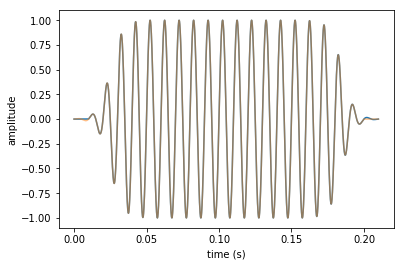

In [203]:
srate=44100
domain, codomain = sine_wave(freq=100, secs=.2, srate=srate, return_domain=True)
ambiguous_angle = 50
stereo_sound, channel_1, channel_2 = stereo_and_ramp(codomain, ambiguous_angle, srate, .05)

# plot the sounds with the left and right channels in different colors on the same axes
play_and_plot(stereo_sound, sound_wave, overlay_channels=True)
sound_len = len(channel_1)

3.2 (5 points) Show how increasing the bandwith of the sound eliminates the ambiguity.

/home/iamroot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.


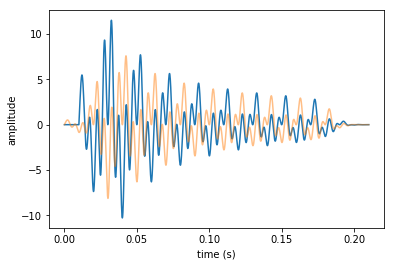

In [211]:
# original frequency
domain, codomain = sine_wave(freq=100, secs=.2, srate=srate, return_domain=True)

# add other frequencies to increase bandwidth
for freq in range(50, 200):
    codomain += sine_wave(freq=freq, secs=.2, srate=srate, return_domain=False)
ambiguous_angle = 50
stereo_sound, channel_1, channel_2 = stereo_and_ramp(codomain, ambiguous_angle, srate, .05)
        
# plot the sounds with the left and right channels in different colors on the same axes
play_and_plot(stereo_sound, sound_wave, overlay_channels=True)

3.3 (10 points) Write a function to estiamte the ITD, $\Delta t$, from a binaural sound as input.  Illustrate with examples.

In [212]:
# we can check our estimate of the itd from the difference in initial silence between the two channels, as well as from
# knowing what the original itd was
def itd_sanity_check(stereo, srate):
    channel_1, channel_2 = stereo[:, 0], stereo[:, 1]
    channel_1_delay = channel_1.shape[0] - np.trim_zeros(channel_1, trim='f').shape[0]
    channel_2_delay = channel_2.shape[0] - np.trim_zeros(channel_2, trim='f').shape[0]
    sample_itd = abs(channel_1_delay - channel_2_delay)
    return sample_itd / srate

In [213]:
# helper function to get correlation
def corr(channel_1, channel_2, t):
    channel_2_tmp = channel_1[t:] # equivalent to channel_2[k+t]
    channel_1_tmp = channel_2[:len(channel_2_tmp)] # equivalent to len(channel_1) - t
    summands = channel_1_tmp*channel_2_tmp
    # normalization is unnecessary as we only care about the max value
    return np.sum(summands)


def stereo_to_itd(channel_1, channel_2, srate):
    return np.argmax([corr(channel_1, channel_2, t) for t in range(0, len(channel_1))]) / srate

In [214]:
# demonstrate with sine wave
angle = 45

sine_sound_wave, real_sound_wave = get_example_sounds()

for sound_wave in (sine_sound_wave, real_sound_wave):
    stereo_sound, channel_1, channel_2 = stereo_and_ramp(sound_wave.codomain, angle, sound_wave.srate, 0, print_itd=True)
    print('estimated ITD: ', stereo_to_itd(channel_1, channel_2, sound_wave.srate))
    print('sanity check for ITD: ', itd_sanity_check(stereo_sound, sound_wave.srate))
    sound_len = len(stereo_sound[:, 0])

ITD:  0.008300818735668165
estimated ITD:  0.008299319727891157
sanity check for ITD:  0.008299319727891157
ITD:  0.008300818735668165
estimated ITD:  0.008299319727891157
sanity check for ITD:  0.008299319727891157


3.4 (5 points)  Use the idealized model above to estimate the lateralization $\theta$ from the ITD.  Illustrate with examples.  Does this correspond to your own perception?  Try different cases and report your results

$$ \Delta t = \frac{r}{c} (\theta+\sin(\theta)) $$

estimated angle at 0 degrees:  0.0
estimated angle at 45 degrees:  44.08150801364129
estimated angle at 90 degrees:  89.70122072034933


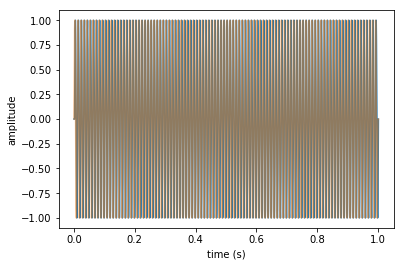

estimated lateralization (degrees from straight ahead):  19.9097319046499


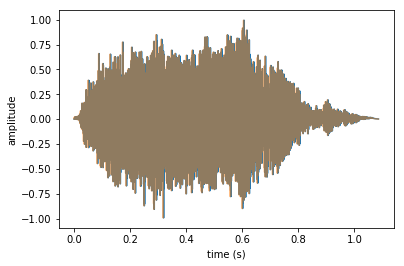

estimated lateralization (degrees from straight ahead):  19.9097319046499


In [215]:
# I'm just using the scipy optimization library to iteratively solve for theta
def itd_to_angle(itd):
    result = minimize_scalar(lambda x: abs(get_itd(x) - itd))
    return result.x

# test against a few representative cases (known from previous inputs)
print('estimated angle at 0 degrees: ', itd_to_angle(0)) # 0 degrees
print('estimated angle at 45 degrees: ', itd_to_angle(.008)) # 45 degrees
print('estimated angle at 90 degrees: ', itd_to_angle(.0234)) # 90 degrees

# and illustrate with examples

angle = 20

sine_sound_wave, real_sound_wave = get_example_sounds()

for sound_wave in (sine_sound_wave, real_sound_wave):
    stereo_sound, channel_1, channel_2 = stereo_and_ramp(sound_wave.codomain, angle, sound_wave.srate, 0)
    play_and_plot(stereo_sound, sound_wave, overlay_channels=True)
    
    estimated_angle = itd_to_angle(stereo_to_itd(channel_1, channel_2, sound_wave.srate))
    print('estimated lateralization (degrees from straight ahead): ', estimated_angle)

### Q4. Exploration (20 points)

Select a concept or topic you want to understand better that is related to the problems in this assignment or is in the readings.  Explore it, and write up and illustrate what you tried and learned.  The general idea is for you to teaching yourself, and it should read like a (relatively brief) tutorial.

In [216]:
# lateralization with iid
# since sound intensity follows the inverse square law, the iid itself is just the square of the difference in distance
# between the ears and the sound source
def get_iid(angle, radius=.09, c=345):
    theta = angle * pi / 180
    distance = 2 * radius * np.sin(theta)
    return float(distance ** 2)

In [217]:
def apply_iid(waveform, angle):
    if angle > 0:
        waveform[:, 0] *= float(1.0 - get_iid(angle))
    else:
        waveform[:, 1] *= float(1.0 - get_iid(angle))
    return waveform

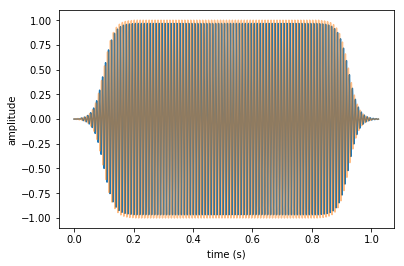

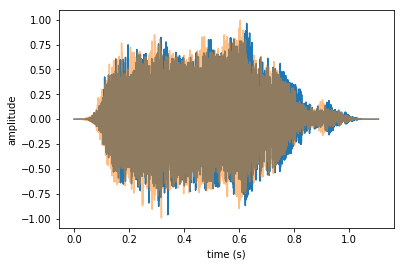

In [219]:
angle = 90

sine_sound_wave, real_sound_wave = get_example_sounds()

for sound_wave in (sine_sound_wave, real_sound_wave):
    stereo_sound, _, _ = stereo_and_ramp(sound_wave.codomain, angle, sound_wave.srate, .2)
    stereo_sound = apply_iid(stereo_sound, angle)
    play_and_plot(stereo_sound, sound_wave, overlay_channels=True)

<img src="geofig.jpg" align="left" style="width: 500px;"/>

In [220]:
# as always, units are in m, degrees, s
def get_interaural_distance(distance, angle, r=.09):
    theta = angle * pi / 180
    l_distance = np.sqrt((r + distance * sin(theta)) ** 2 + (distance * cos(theta)) ** 2)
    r_distance = np.sqrt((r - distance * sin(theta)) ** 2 + (distance * cos(theta)) ** 2)
    interaural_distance = abs(l_distance - r_distance)
    print('interaural distance: ', interaural_distance)
    return interaural_distance


def get_itd(angle, distance, radius=.09, c=345):
    theta = angle * pi / 180
    return get_interaural_distance(distance, angle) / c


def convert_to_stereo(waveform, angle, distance, srate, print_itd=False):
    itd = get_itd(angle, distance)
    if print_itd:
        print('ITD: ', itd)
    left_channel = waveform
    right_channel = np.pad(waveform, pad_width=(int(itd*srate), 0), mode='constant', constant_values=0)
    # if angle < 0, we want the offset in the other direction, so we can just swap the channels
    if angle > 0:
        left_channel, right_channel = right_channel, left_channel
    return pad_channels(left_channel, right_channel)


def stereo_and_ramp(wave, angle, distance, srate, ramp_len, print_itd=False):
    channel_1, channel_2 = convert_to_stereo(wave, angle, distance, srate, print_itd=print_itd)
    stereo_sound = mix_channels(channel_1, channel_2)
    channel_1 = apply_ramp(channel_1, ramp_len, srate)
    channel_2 = apply_ramp(channel_2, ramp_len, srate)
    stereo_sound[:, 0], stereo_sound[:, 1] = channel_1, channel_2
    return stereo_sound, channel_1, channel_2

In [221]:
def get_iid(angle, distance, radius=.09, c=345):
    theta = angle * pi / 180
    distance = get_interaural_distance(distance, angle)
    return float(distance ** 2)


def apply_iid(waveform, angle, distance, print_iid=False):
    iid = get_iid(angle, distance)
    if print_iid:
        print('IID: ', iid)
    if angle > 0:
        waveform[:, 0] *= float(1.0 - iid)
    else:
        waveform[:, 1] *= float(1.0 - iid)
    return waveform

interaural distance:  0.18000000000000005
ITD:  0.0005217391304347828
interaural distance:  0.18000000000000005
IID:  0.03240000000000002


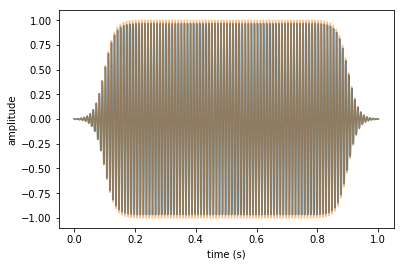

interaural distance:  0.18000000000000005
ITD:  0.0005217391304347828
interaural distance:  0.18000000000000005
IID:  0.03240000000000002


In [ ]:
angle = 90
distance = 1

sine_sound_wave, real_sound_wave = get_example_sounds()

for sound_wave in (sine_sound_wave, real_sound_wave):
    stereo_sound, _, _ = stereo_and_ramp(sound_wave.codomain, angle, distance, sound_wave.srate, .2, print_itd=True)
    stereo_sound = apply_iid(stereo_sound, angle, distance, print_iid=True)
    play_and_plot(stereo_sound, sound_wave, overlay_channels=True)

In [1156]:
# TODO: observations
# it doesn't really change much in terms of perception (or numerially, still the same to many decimal places out), but it's
# technically more accurate
# the iid though helps a lot perceptually